In [102]:
import os
import shutil

# --- CONFIGURATION ---
# Replace these paths with your ACTUAL folder locations
NORMAL_DIR = "landmarks_npy"          # Folder with original data
MIRROR_DIR = "landmarks_npy_mirrored" # Folder with mirrored data
DEST_DIR = "landmarks_combined"       # Where everything will go

os.makedirs(DEST_DIR, exist_ok=True)

print("Starting Merge...")

# 1. Copy Normal Files (Keep names the same)
print(f"Copying files from {NORMAL_DIR}...")
for filename in os.listdir(NORMAL_DIR):
    if filename.endswith(".npy") and "_mir" not in filename:
        src = os.path.join(NORMAL_DIR, filename)
        dst = os.path.join(DEST_DIR, filename)
        shutil.copy2(src, dst)

# 2. Copy Mirrored Files (Add '_mir' suffix)
print(f"Copying and Renaming files from {MIRROR_DIR}...")
for filename in os.listdir(MIRROR_DIR):
    if filename.endswith(".npy"):
        src = os.path.join(MIRROR_DIR, filename)
        
        # Create new name: wlasl_123.npy -> wlasl_123_mir.npy
        new_name = filename.replace(".npy", "_mir.npy")
        dst = os.path.join(DEST_DIR, new_name)
        
        shutil.copy2(src, dst)

print(f"Success! All files merged into '{DEST_DIR}'.")
print("Please update your notebook to point to this new folder.")

Starting Merge...
Copying files from landmarks_npy...
Copying and Renaming files from landmarks_npy_mirrored...
Success! All files merged into 'landmarks_combined'.
Please update your notebook to point to this new folder.


In [1]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import mediapipe as mp
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    LSTM, Dense, Dropout, Conv1D, Bidirectional, BatchNormalization, Activation,
    Input, GlobalAveragePooling1D, GlobalMaxPooling1D, Concatenate, SpatialDropout1D
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

# --- CONFIGURATION ---
VIDEO_SOURCE_DIRS = ["videos", "videos_msasl"] 
# POINT THIS TO YOUR NEW MERGED FOLDER
LANDMARKS_DIR = "landmarks_combined" 

# Model Constraints
SEQ_LEN = 30       
MAX_FRAMES = 75    
NUM_LANDMARKS = 75 
TARGET_SAMPLES = 1200 

# --- TARGET LIST (Robust) ---
TARGET_GLOSSES = [
    "me", "you", "we", "they", "hello", 
    "friend", "house", 
    "yes", "no", "fine", "help", "meet", "good",
    "want", "have", "like", "love", "go", "walk", 
    "play", "work", "learn", "eat", "drink", "finish",
    "book", "family", "school", "computer", "deaf", "j", "z"
]
TARGET_GLOSSES = [g.lower() for g in TARGET_GLOSSES]

GLOSS_MAPPING = {"them": "they"}

print(f"Configuration Loaded. Targeting {len(TARGET_GLOSSES)} words.")

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Configuration Loaded. Targeting 32 words.


In [2]:
# Master list of videos to process
video_file_list = []
gloss_counts = defaultdict(int)

print("Scanning video folders...")

for source_dir in VIDEO_SOURCE_DIRS:
    if not os.path.exists(source_dir):
        print(f"Warning: Folder '{source_dir}' not found. Skipping.")
        continue
        
    for root, dirs, files in os.walk(source_dir):
        folder_name = os.path.basename(root).lower()
        
        # Resolve Synonyms
        target_gloss = folder_name
        if folder_name in GLOSS_MAPPING:
            target_gloss = GLOSS_MAPPING[folder_name]
            
        # Check if it's a target
        if target_gloss in TARGET_GLOSSES:
            for file in files:
                if file.endswith((".mp4", ".mov", ".avi")):
                    full_path = os.path.join(root, file)
                    vid_id = os.path.splitext(file)[0]
                    
                    video_file_list.append({
                        "path": full_path,
                        "gloss": target_gloss,
                        "id": vid_id
                    })
                    gloss_counts[target_gloss] += 1

print(f"\nFound {len(video_file_list)} videos total.")
print("-" * 30)
for gloss in TARGET_GLOSSES:
    print(f"{gloss:<10}: {gloss_counts[gloss]}")

Scanning video folders...

Found 1937 videos total.
------------------------------
me        : 40
you       : 54
we        : 36
they      : 35
hello     : 55
friend    : 63
house     : 46
yes       : 69
no        : 73
fine      : 57
help      : 63
meet      : 49
good      : 62
want      : 67
have      : 51
like      : 70
love      : 38
go        : 55
walk      : 57
play      : 52
work      : 48
learn     : 63
eat       : 75
drink     : 74
finish    : 76
book      : 85
family    : 67
school    : 70
computer  : 66
deaf      : 71
j         : 75
z         : 75


In [3]:
mp_holistic = mp.solutions.holistic

def extract_landmarks(results):
    """Extracts pose, left_hand, right_hand into a flat vector."""
    vec = []
    # Pose (33 landmarks * 3 coords)
    if results.pose_landmarks:
        for lm in results.pose_landmarks.landmark:
            vec.extend([lm.x, lm.y, lm.z])
    else:
        vec.extend([0.0] * 99)
    # Left Hand (21 * 3)
    if results.left_hand_landmarks:
        for lm in results.left_hand_landmarks.landmark:
            vec.extend([lm.x, lm.y, lm.z])
    else:
        vec.extend([0.0] * 63)
    # Right Hand (21 * 3)
    if results.right_hand_landmarks:
        for lm in results.right_hand_landmarks.landmark:
            vec.extend([lm.x, lm.y, lm.z])
    else:
        vec.extend([0.0] * 63)
    return vec

print("Starting extraction...")
with mp_holistic.Holistic(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1) as holistic:
    
    for item in video_file_list:
        vid_id = item["id"]
        gloss = item["gloss"]
        video_path = item["path"]
        
        prefix = "msasl" if "msasl" in video_path.lower() else "wlasl"
        unique_name = f"{prefix}_{vid_id}"
        npy_path = os.path.join(LANDMARKS_DIR, f"{unique_name}.npy")
        
        if os.path.exists(npy_path):
            continue
            
        cap = cv2.VideoCapture(video_path)
        frames_data = []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret: break
            
            results = holistic.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            frames_data.append(extract_landmarks(results))
            
        cap.release()
        
        if len(frames_data) > 0:
            np.save(npy_path, np.array(frames_data, dtype=np.float32))
            print(f"Extracted: {unique_name} ({gloss})")

print("Extraction complete.")

Starting extraction...
Extraction complete.


In [4]:
# 1. Scan NPY folder for "Base" IDs only
valid_samples = [] # (base_filename, gloss)
processed_count = 0

print(f"Scanning {LANDMARKS_DIR}...")

for item in video_file_list:
    vid_id = item["id"]
    gloss = item["gloss"]
    prefix = "msasl" if "msasl" in item["path"].lower() else "wlasl"
    
    # We check for the NORMAL file. 
    unique_name = f"{prefix}_{vid_id}"
    npy_path = os.path.join(LANDMARKS_DIR, f"{unique_name}.npy")
    
    if os.path.exists(npy_path):
        valid_samples.append((unique_name, gloss))
        processed_count += 1

print(f"Found {processed_count} unique video sources (excluding mirrors).")

# 2. Group by Gloss
gloss_map = defaultdict(list)
for vid_name, gloss in valid_samples:
    gloss_map[gloss].append(vid_name)

# 3. Stratified Split (Split the SOURCES, not the files)
train_vids_base = []
val_vids_base = []

for gloss, vids in gloss_map.items():
    if len(vids) < 3:
        train_vids_base.extend([(v, gloss) for v in vids])
        continue
    
    t_vids, v_vids = train_test_split(vids, test_size=0.2, random_state=42)
    train_vids_base.extend([(v, gloss) for v in t_vids])
    val_vids_base.extend([(v, gloss) for v in v_vids])

# 4. Expand to include Mirrored Files
# This is where we verify if the _mir version exists and add it to the same set
train_vids = []
val_vids = []

def add_files(base_list, target_list):
    for vid, gloss in base_list:
        # Add Original
        target_list.append((vid, gloss))
        
        # Add Mirror (if exists)
        mir_path = os.path.join(LANDMARKS_DIR, f"{vid}_mir.npy")
        if os.path.exists(mir_path):
            target_list.append((f"{vid}_mir", gloss))

add_files(train_vids_base, train_vids)
add_files(val_vids_base, val_vids)

print(f"Final Training Set: {len(train_vids)} files (Original + Mirrored)")
print(f"Final Validation Set: {len(val_vids)} files (Original + Mirrored)")

Scanning landmarks_combined...
Found 1937 unique video sources (excluding mirrors).
Final Training Set: 3076 files (Original + Mirrored)
Final Validation Set: 798 files (Original + Mirrored)


In [5]:
def pre_process_landmarks(data):
    # 1. Duration Capping
    if len(data) > MAX_FRAMES:
        data = data[:MAX_FRAMES]
    
    # 2. Interpolation
    df = pd.DataFrame(data)
    df = df.replace(0.0, np.nan)
    df = df.interpolate(method='linear', axis=0, limit_direction='both')
    df = df.fillna(0.0)
    data = df.values.astype(np.float32)
    
    # Reshape
    frames = data.reshape(-1, NUM_LANDMARKS, 3)
    
    # 3. Body-Centric Normalization
    for i in range(frames.shape[0]):
        frame = frames[i]
        left_shoulder = frame[11]
        right_shoulder = frame[12]
        shoulder_center = (left_shoulder + right_shoulder) / 2.0
        width = np.linalg.norm(left_shoulder - right_shoulder) + 1e-6
        
        frame = (frame - shoulder_center) / (width / 2.0)
        frames[i] = frame

    return frames.reshape(-1, NUM_LANDMARKS * 3)

def resize_sequence(sequence, target_len=SEQ_LEN):
    norm_seq = pre_process_landmarks(sequence)
    res = np.zeros((target_len, norm_seq.shape[1]))
    for j in range(norm_seq.shape[1]):
        res[:, j] = np.interp(
            np.linspace(0, len(norm_seq)-1, target_len),
            np.arange(len(norm_seq)),
            norm_seq[:, j]
        )
    return res

def augment_data(sequence):
    """Apply random scaling, rotation, translation, AND Mirroring."""
    seq = sequence.copy().reshape(-1, NUM_LANDMARKS, 3)

    # Scaling
    seq[:, :, 0] *= random.uniform(0.8, 1.2)
    seq[:, :, 1] *= random.uniform(0.8, 1.2)
    
    # Translation
    seq[:, :, 0] += random.uniform(-0.1, 0.1)
    seq[:, :, 1] += random.uniform(-0.1, 0.1)

    # Rotation
    theta = random.uniform(-0.15, 0.15)
    c, s = np.cos(theta), np.sin(theta)
    for t in range(seq.shape[0]):
        x, y = seq[t, :, 0], seq[t, :, 1]
        seq[t, :, 0] = x*c - y*s
        seq[t, :, 1] = x*s + y*c
            
    return seq.reshape(-1, NUM_LANDMARKS*3)

In [6]:
X_train, y_train = [], []
X_val, y_val = [] , []

label_map = {label: num for num, label in enumerate(TARGET_GLOSSES)}

# 1. Group Training Data
train_by_gloss = defaultdict(list)
for vid, gloss in train_vids:
    train_by_gloss[gloss].append(vid)

# 2. Process Training (Balanced)
print("Processing Training Data...")
for gloss, vids in train_by_gloss.items():
    if not vids: continue
    
    num_videos = len(vids)
    aug_per_video = int(TARGET_SAMPLES / num_videos)
    if aug_per_video < 1: aug_per_video = 1
    
    for vid in vids:
        path = os.path.join(LANDMARKS_DIR, f"{vid}.npy")
        if not os.path.exists(path): continue
        data = np.load(path)
        
        # Add Original
        X_train.append(resize_sequence(data))
        y_train.append(label_map[gloss])
        
        # Add Augmentations
        for _ in range(aug_per_video - 1):
            aug = augment_data(resize_sequence(data))
            X_train.append(aug)
            y_train.append(label_map[gloss])

# 3. Process Validation (No Augmentation)
print("Processing Validation Data...")
for vid, gloss in val_vids:
    path = os.path.join(LANDMARKS_DIR, f"{vid}.npy")
    if not os.path.exists(path): continue
    data = np.load(path)
    
    X_val.append(resize_sequence(data))
    y_val.append(label_map[gloss])

X_train = np.array(X_train)
X_val = np.array(X_val)

# --- ONE-HOT ENCODING (Required for Focal Loss) ---
y_train = to_categorical(np.array(y_train), num_classes=len(TARGET_GLOSSES))
y_val = to_categorical(np.array(y_val), num_classes=len(TARGET_GLOSSES))

print(f"Final Training Shape: {X_train.shape}, {y_train.shape}")
print(f"Final Validation Shape: {X_val.shape}, {y_val.shape}")

Processing Training Data...
Processing Validation Data...
Final Training Shape: (37200, 30, 225), (37200, 32)
Final Validation Shape: (798, 30, 225), (798, 32)


In [7]:
# --- Custom Focal Loss ---
def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Softmax version of focal loss.
    gamma: Focusing parameter (higher = focuses more on hard examples)
    alpha: Balancing parameter
    """
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * y_true * K.pow((1 - y_pred), gamma)
        return K.sum(weight * cross_entropy, axis=-1)
    return focal_loss_fixed
# --- ROBUST MODEL ARCHITECTURE (The "Sweet Spot") ---
def build_robust_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # 1. Spatio-Temporal Feature Extraction
    # CHANGED: kernel_size 3 -> 5 (Fixes "Need" wiggle)
    # KEPT: filters=128 (Keeps "You" handshape visible)
    x = Conv1D(128, kernel_size=5, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.1)(x) # Keeps "No" head data safe
    
    # 2. Deep Temporal Modeling (Bi-LSTM)
    # CHANGED: Dropout 0.3 -> 0.2 (Helps it learn faster since we were underfitting)
    x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2))(x)
    x = BatchNormalization()(x)
    
    # CHANGED: Units 32 -> 64 (Fixes "No" context)
    x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2))(x)
    x = BatchNormalization()(x)
    
    # 3. Dual Pooling Head
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = Concatenate()([avg_pool, max_pool])
    
    # 4. Classifier
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x) 
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x) 
    
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name="Robust_ASL_Model")
    return model

# --- COMPILE & TRAIN ---
input_shape = (SEQ_LEN, NUM_LANDMARKS * 3) 
model_robust = build_robust_model(input_shape, len(TARGET_GLOSSES))
model_robust.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# KEPT: Alpha=0.35 (Keeps "Me" perfect)
model_robust.compile(optimizer=optimizer, loss=categorical_focal_loss(gamma=2.0, alpha=0.35), metrics=['categorical_accuracy'])

callbacks = [
    ModelCheckpoint("robust_word_model.keras", save_best_only=True, monitor="val_loss", mode="min"),
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

history_robust = model_robust.fit(
    X_train, y_train, 
    epochs=1000, 
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Model: "Robust_ASL_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 225)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 30, 128)   │    144,128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 30, 128)   │        512 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 30, 128)   │          0 │ batch_normalizat… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 30, 128)   │     98,816 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 128)   │        512 │ bidirectional[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 30, 128)   │     98,816 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 128)   │        512 │ bidirectional_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     16,448 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 362,080 (1.38 MB)

 Trainable params: 361,184 (1.38 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/1000
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - categorical_accuracy: 0.0977 - loss: 1.2515 - val_categorical_accuracy: 0.2356 - val_loss: 0.8760 - learning_rate: 1.0000e-04
Epoch 2/1000
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - categorical_accuracy: 0.1940 - loss: 0.9519 - val_categorical_accuracy: 0.3634 - val_loss: 0.6820 - learning_rate: 1.0000e-04
Epoch 3/1000
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - categorical_accuracy: 0.3007 - loss: 0.7674 - val_categorical_accuracy: 0.5276 - val_loss: 0.5297 - learning_rate: 1.0000e-04
Epoch 4/1000
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - categorical_accuracy: 0.4081 - loss: 0.6210 - val_categorical_accuracy: 0.5877 - val_loss: 0.4482 - learning_rate: 1.0000e-04
Epoch 5/1000
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - categorical_accuracy: 0.4974 - loss: 0.5120 - val_categorical_accuracy: 0.6241 - val_loss: 0.3920 - learning_rate: 1.0000e-04
Epoch 6/1000
2325/2325 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - categorica

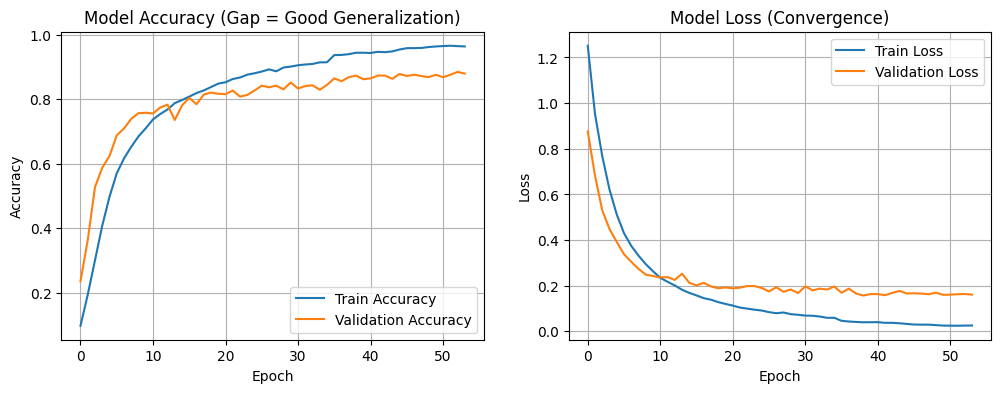

In [8]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_robust.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history_robust.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (Gap = Good Generalization)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_robust.history['loss'], label='Train Loss')
plt.plot(history_robust.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Convergence)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

--- Classification Report (Robust Model) ---
              precision    recall  f1-score   support

          me       0.76      1.00      0.86        16
         you       0.47      0.36      0.41        22
          we       0.75      0.94      0.83        16
        they       0.91      0.71      0.80        14
       hello       0.76      0.86      0.81        22
      friend       0.92      0.92      0.92        26
       house       1.00      0.90      0.95        20
         yes       0.62      0.89      0.74        28
          no       0.96      0.77      0.85        30
        fine       0.85      0.92      0.88        24
        help       0.93      1.00      0.96        26
        meet       1.00      1.00      1.00        20
        good       0.84      0.81      0.82        26
        want       0.93      1.00      0.97        28
        have       1.00      1.00      1.00        22
        like       0.96      0.82      0.88      

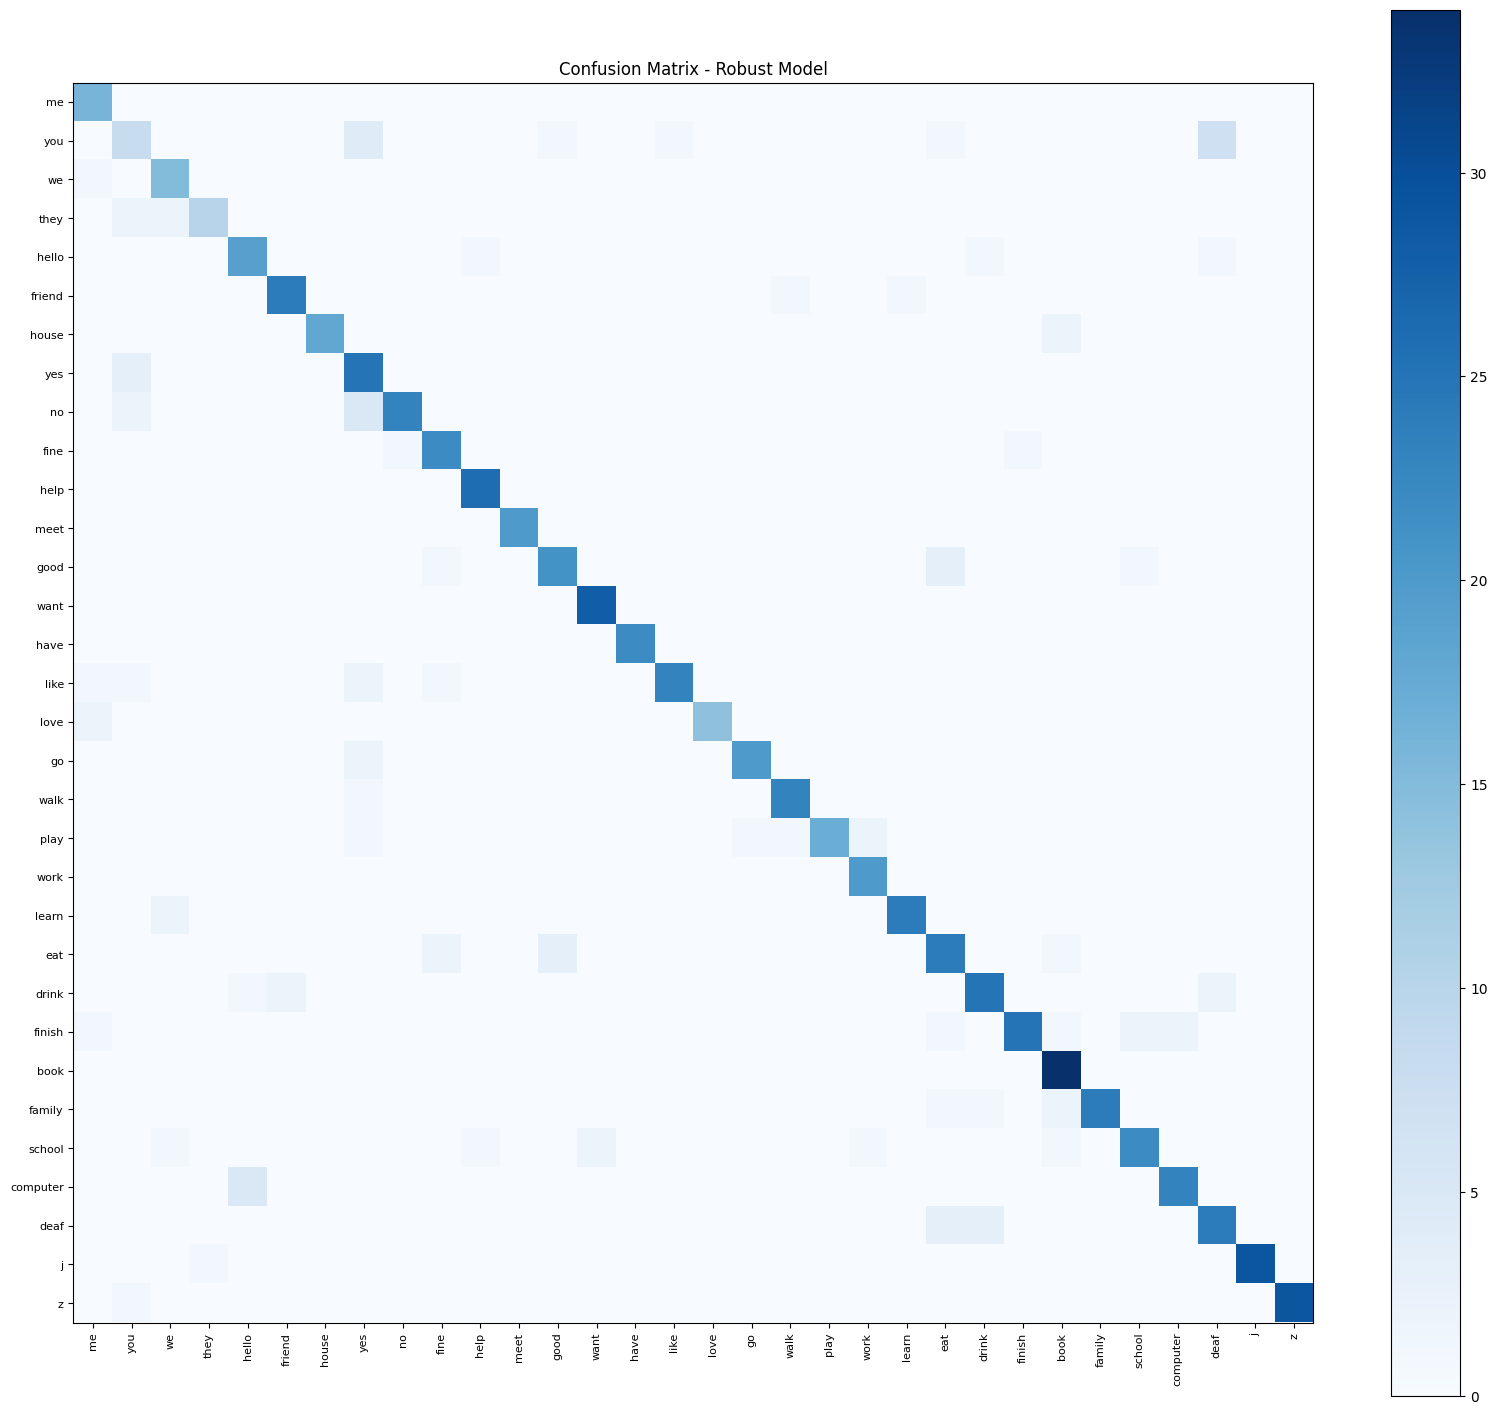

Model saved as robust_word_model.h5


In [9]:
# Load best weights
model_robust.load_weights("robust_word_model.keras")

# Predictions
y_pred_robust = model_robust.predict(X_val)

# Convert One-Hot back to Class Indices
y_true_classes = np.argmax(y_val, axis=1)
y_pred_classes_robust = np.argmax(y_pred_robust, axis=1)

print("\n--- Classification Report (Robust Model) ---")
print(classification_report(
    y_true_classes, 
    y_pred_classes_robust, 
    target_names=TARGET_GLOSSES, 
    labels=np.arange(len(TARGET_GLOSSES)) 
))

# Confusion Matrix
plt.figure(figsize=(20, 18))
cm = confusion_matrix(y_true_classes, y_pred_classes_robust, labels=np.arange(len(TARGET_GLOSSES)))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Robust Model")
plt.colorbar()
tick_marks = np.arange(len(TARGET_GLOSSES))
plt.xticks(tick_marks, TARGET_GLOSSES, rotation=90, fontsize=8)
plt.yticks(tick_marks, TARGET_GLOSSES, fontsize=8)
plt.show()

# Save final model
model_robust.save("robust_word_model.h5")
print("Model saved as robust_word_model.h5")

In [96]:
import os

# --- CONFIGURATION ---
MSASL_SOURCE_DIR = "videos_msasl"  # Only look in the MSASL folder
LANDMARKS_DIR = "landmarks_npy"
TARGET_GLOSS = "z"                 # The word/letter to target

print(f"Scanning '{MSASL_SOURCE_DIR}' for gloss '{TARGET_GLOSS}'...")

deleted_count = 0

# 1. Walk through the MSASL folder specifically
for root, dirs, files in os.walk(MSASL_SOURCE_DIR):
    folder_name = os.path.basename(root).lower()
    
    # 2. Only process if we are in the 'z' folder
    if folder_name == TARGET_GLOSS:
        for file in files:
            if file.endswith((".mp4", ".mov", ".avi")):
                # Get the ID from the video filename
                vid_id = os.path.splitext(file)[0]
                
                # Construct the specific MSASL filename pattern
                # We check for both standard and mirrored versions just in case
                possible_names = [
                    f"msasl_{vid_id}.npy",
                    f"msasl_{vid_id}_mir.npy"
                ]
                
                for npy_name in possible_names:
                    npy_path = os.path.join(LANDMARKS_DIR, npy_name)
                    
                    if os.path.exists(npy_path):
                        os.remove(npy_path)
                        deleted_count += 1
                        # print(f"Deleted: {npy_name}") # Uncomment to see details

print(f"\nSuccess! Deleted {deleted_count} MSASL files for '{TARGET_GLOSS}'.")
print("WLASL 'z' files remain untouched.")

Scanning 'videos_msasl' for gloss 'z'...

Success! Deleted 0 MSASL files for 'z'.
WLASL 'z' files remain untouched.
